In [1]:
import numpy as np
import matplotlib.pyplot as plt
import zetapy as zt
import timewizard.perievent as tw
import timewizard.util as twu
from tqdm.notebook import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

# Generate some fake data

In [3]:
np.random.seed(15)
fs = 100
total_time = 1000  # seconds
n_events = 10
t = np.arange(0,total_time, 1/fs)  # sampled at 100 Hz
y = np.zeros(t.shape) + 0.5 * np.random.normal(size=t.shape)
event_times = np.sort(np.random.random(size=n_events) * total_time)
event_template = np.arange(10,0,-1 * 1/fs * 10)  # rough approx of a gcamp trace
event_len = len(event_template)
for evt in event_times:
    start_idx = tw.index_of_nearest_value(t, [evt], force_side="right")[0]
    y[start_idx:(start_idx + event_len)] += event_template

Here is how the data look overall

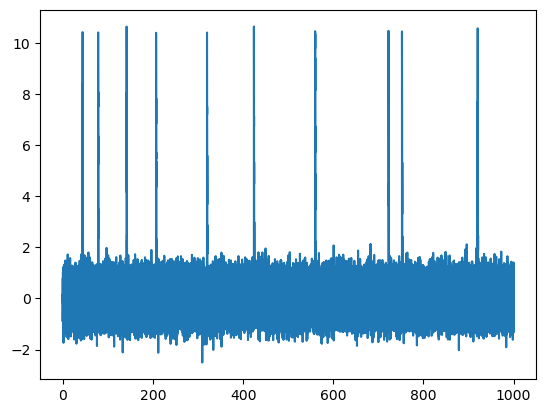

In [4]:
plt.plot(t,y)

Here is what one event looks like

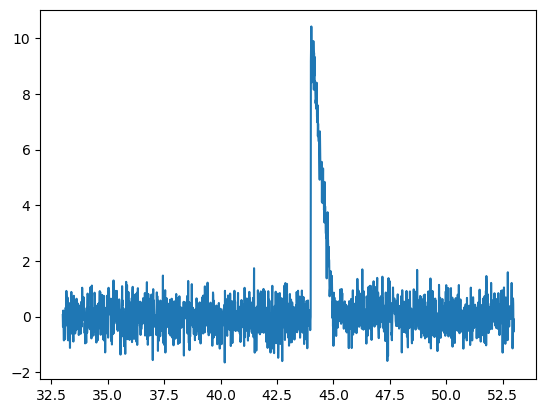

In [5]:
s = slice(int(event_times[0] - 10)*fs, int(event_times[0] + 10)*fs)
plt.plot(t[s],y[s])

And if we align all the events, we can see they're pretty similar

(array([ 0, 25, 50, 75]), array([0.  , 0.25, 0.5 , 0.75]))

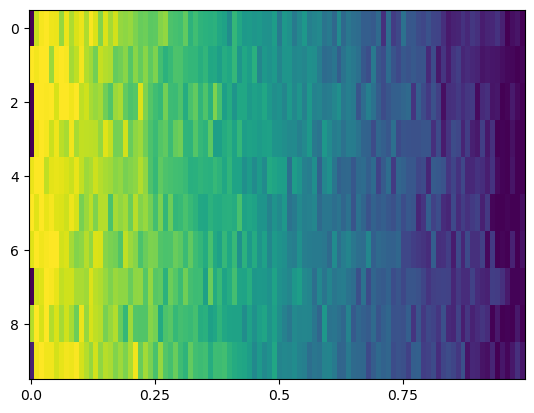

In [6]:
ts, traces = tw.perievent_traces(t, y, event_times, (0,1), fs=fs)
plt.imshow(traces, aspect='auto', interpolation='none', vmin=0, vmax=10)
twu.xticks_from_timestamps(ts, interval=0.25)

Here is an example of how we will efficiently stitch + shuffle the data in zetapy

In [7]:
maxDur = 1
maxJit = 2
stitched = np.hstack(traces)
fictive_stitched_t = (  # ie 0.001, 0.002,... 1.001, 1.002, ..., 2.001, 2.002,...
    np.tile(ts, traces.shape[0]) 
    + np.repeat(np.arange(traces.shape[0]) * maxDur, traces.shape[1])
)  
fictive_og_evt_times = np.arange(traces.shape[0]) * maxDur  # ie 0, 1, 2...
fictive_jittered_evt_times = fictive_og_evt_times + 2*maxJit*maxDur*(np.random.random(len(fictive_og_evt_times)) - 0.5)
fictive_jittered_evt_times = fictive_jittered_evt_times[(fictive_jittered_evt_times > 1) & (fictive_jittered_evt_times<9)]  # filter jitters that will give boundary errors
_, jittered_traces = tw.perievent_traces(fictive_stitched_t, stitched, fictive_jittered_evt_times, (0,1), fs=fs)

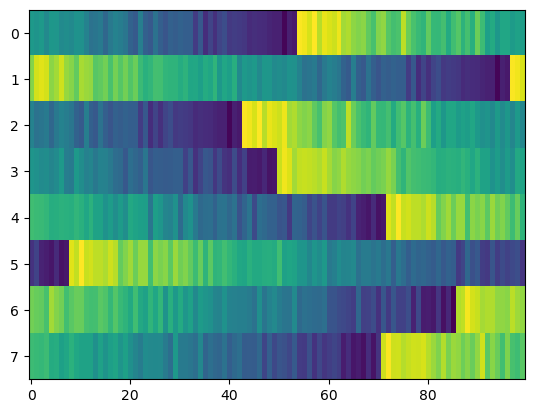

In [8]:
plt.imshow(jittered_traces, aspect='auto', interpolation='none')

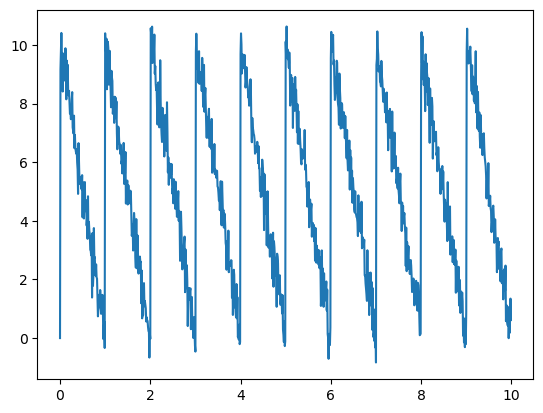

In [9]:
plt.plot(fictive_stitched_t, stitched)

# Run og zetapy

In [91]:
# %timeit p, stats = zt.og_main.zetatstest(t, y, event_times, dblUseMaxDur=1)
# print(p)

1.33 s ± 4.14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
0.000152803346758712


In [35]:
p, stats = zt.og_main.zetatstest(t, y, event_times, dblUseMaxDur=1)
print(p)

0.00012884291855264074


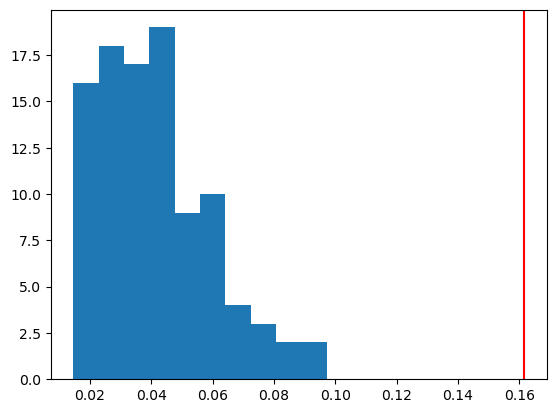

In [36]:
plt.hist(stats['vecMaxRandD'])
plt.axvline(stats['dblMaxD'], color='r')

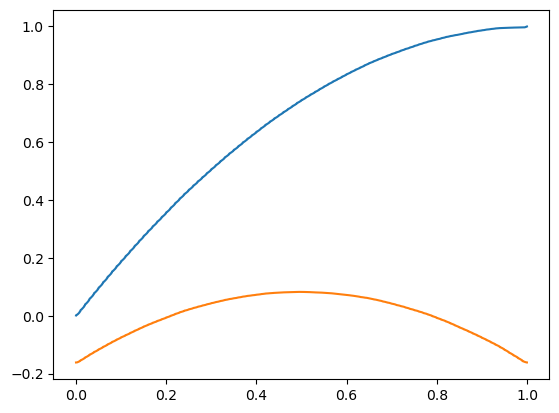

In [37]:
plt.plot(stats['vecRealTime'], stats['vecRealFrac'])
plt.plot(stats['vecRealTime'], stats['vecRealDeviation'])

In [38]:
pvals = []
for _ in tqdm(range(100)):
    p, stats = zt.og_main.zetatstest(t, y, event_times, dblUseMaxDur=1)
    pvals.append(p)

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 1.0, 'OG zetapy zetatstest')

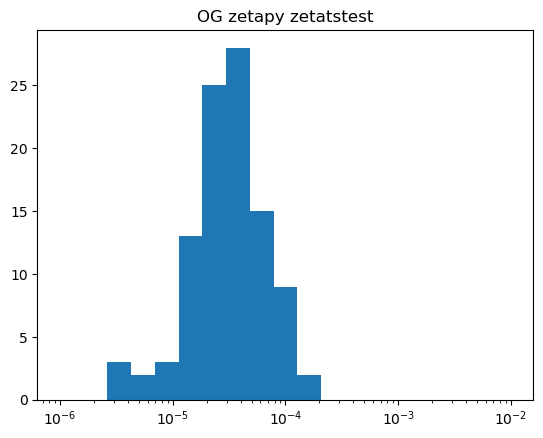

In [39]:
bins = np.logspace(-6,-2, num=20)
plt.hist(pvals, bins=bins)
plt.xscale("log")
plt.title("OG zetapy zetatstest")

In [29]:
p, stats = zt.og_main.zetatstest(t, y, event_times, dblUseMaxDur=1)
print(p)

9.678546317615222e-06


# Run refactored zetapy

In [28]:
%timeit p, stats = zt.zetatstest(t, y, event_times, dblUseMaxDur=1)
print(p)

/Users/jonahpearl/Documents/PiN/Datta_lab/Local_code/zetapy/zetapy/ts_dependencies.py:594: RuntimeWarning: Mean of empty slice
  vecThisFrac = np.cumsum(vecMeanTrace) / np.sum(vecMeanTrace)


61.4 ms ± 367 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
4.949185165592507e-05


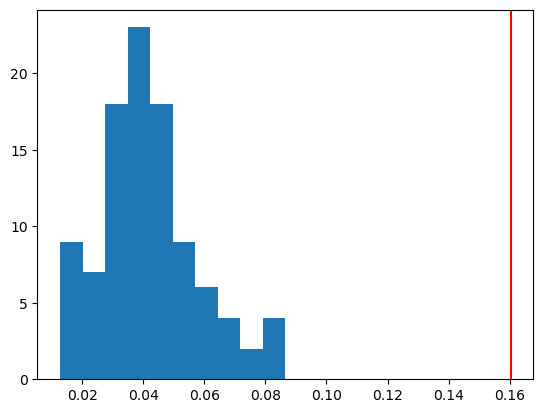

In [29]:
plt.hist(stats['vecMaxRandD'])
plt.axvline(stats['dblMaxD'], color='r')

In [30]:
%timeit p, stats = zt.zetatstest(t, y, event_times, dblUseMaxDur=1, fs=fs)
print(p)

19.7 ms ± 361 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
4.949185165592507e-05


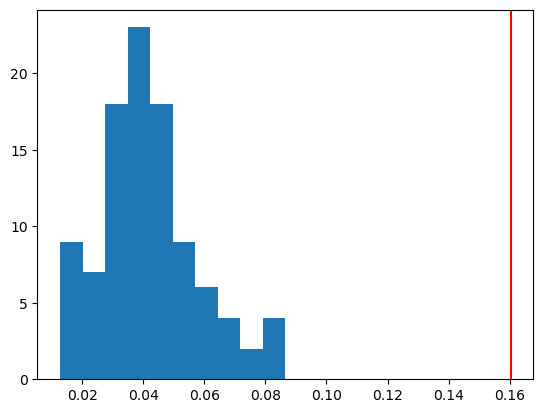

In [31]:
plt.hist(stats['vecMaxRandD'])
plt.axvline(stats['dblMaxD'], color='r')

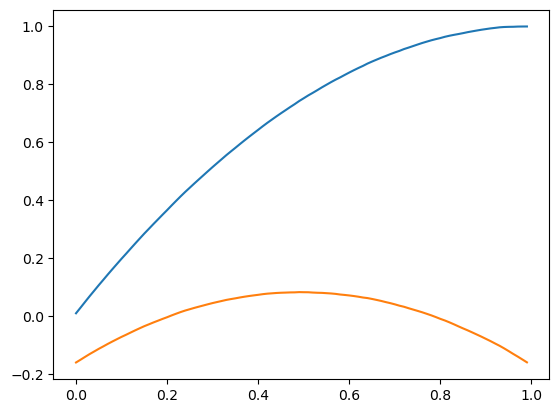

In [32]:
plt.plot(stats['vecRealTime'], stats['vecRealFrac'])
plt.plot(stats['vecRealTime'], stats['vecRealDeviation'])

In [33]:
pvals = []
for _ in range(100):
    p, stats = zt.zetatstest(t, y, event_times, dblUseMaxDur=1, fs=fs)
    pvals.append(p)

Text(0.5, 1.0, 'Refactor zetapy zetatstest')

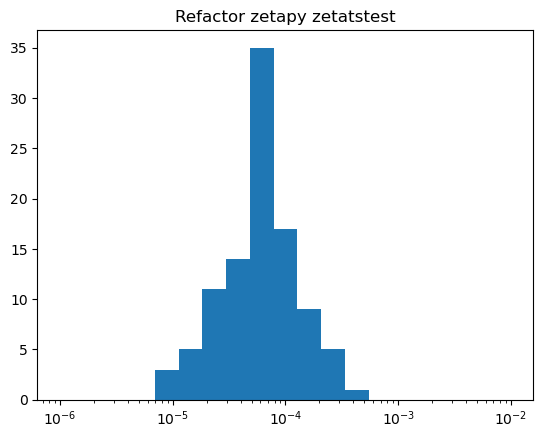

In [34]:
bins = np.logspace(-6,-2, num=20)
plt.hist(pvals, bins=bins)
plt.xscale("log")
plt.title("Refactor zetapy zetatstest")